# Debug Fractions

here I develop the compute_fraction script and plot functions

In [1]:
%cd ../

/Users/jesteves/Documents/GitHub/galaxyFormation


In [9]:
import os
import sys
sys.path.append('./scripts')
from file_loc import FileLocs
from compute_fractions import *

In [10]:
class computeFraction:
    """This class provides a set of calculantions to compute the fraction and bootstrap errors
    """
    def __init__(self, name, path='../data/', key='all'):
        print('\nWelcome to our cluster enviromental effects tools')
        print('probablity: %s'%name)
        self.name = name
        self.path = path
        self.key  = key
        self.outfile_base = path+'outputs/%s/{name}_{var}.npy'%(key)
        check_dir(path+'outputs/%s/'%key)
    
    def add_probabilities(self, p, p_orbital, p_infall, p_interlopers, rn):
        self.data = {'p':p,'p_orbital':p_orbital,'p_infall':p_infall,'p_interlopers':p_interlopers,'rn':rn}
                        
    def run(self, xlabel, xvar, xbins, nBootStrap=10, write=False, is_field=False):
        # set bins
        nbins = xbins.size-1
        self.data[xlabel] = xvar
        
        # initiate dataframe
        df = pd.DataFrame(self.data)
        
        # initiate output arrays
        self.initiate_arrays(nsize=nbins, nBootStrap=nBootStrap)
        
        # compute fraction
        for i in range(nBootStrap):
            df2 = df.dropna(subset=['p_orbital'], how='all', inplace=True)
            vec = df2.sample(frac=1.0, replace=True).to_numpy().T

            xkeys, xmed = make_bins(vec[-1, :], xbins)
            
            frac1 = np.array([compute_fraction(vec[1, idx], vec[0, idx]) for idx in xkeys]).T
            frac2 = np.array([compute_fraction(vec[2, idx], vec[0, idx]) for idx in xkeys]).T
            frac3 = np.array([compute_fraction(vec[3, idx], vec[0, idx]) for idx in xkeys]).T
            frac4 = np.array([compute_fraction(vec[3, idx], vec[0, idx]) for idx in xkeys]).T
            frac12= np.array([compute_fraction(vec[1, idx]+vec[2, idx], vec[0, idx]) for idx in xkeys]).T
            
            frac4 = np.where(frac4<1.,np.median(frac4),frac4)
            
            if is_field:
                frac3 = frac4
                
            qfrac1 = quenching_fraction_excess(frac2, frac1)
            qfrac2 = quenching_fraction_excess(frac3, frac1)
            qfrac3 = quenching_fraction_excess(frac3, frac2)
            qfrac4 = quenching_fraction_excess(frac4, frac12)

            self.frac1[:, i] = frac1
            self.frac2[:, i] = frac2
            self.frac3[:, i] = frac3
            self.frac4[:, i] = frac4
        
            self.qfrac1[:, i] = qfrac1
            self.qfrac2[:, i] = qfrac2
            self.qfrac3[:, i] = qfrac3
            self.qfrac4[:, i] = qfrac4
        
        self.xmed = xmed
        
        if write:
            var = [self.xmed, self.frac1, self.frac2, self.frac3,\
                   self.qfrac1, self.qfrac2, self.qfrac3]
            #outfile = f'{self.path}/tmp/{xlabel}_{self.name}.npy'
            self.write(self.outfile_base, var, q1=16, q3=84)
            
        pass

    def run_kde(self, xlabel, xvar, xbins, bw=None, is_field=False, nBootStrap=10, write=False, radial_cut=True):
        # set bins
        nbins = xbins.size
        self.data[xlabel] = xvar
        
        # initiate dataframe
        df = pd.DataFrame(self.data)
        
        # initiate output arrays
        self.initiate_arrays(nsize=nbins, nBootStrap=nBootStrap)
        
        if radial_cut:
            inner_cut = xbins<=2.
            outer_cut = xbins>2.

        # compute fraction
        for i in range(nBootStrap):
            vec = df.to_numpy().T
            frac1 = compute_fraction_kde(xbins, vec[-1], vec[1], vec[0], bw=bw)
            frac2 = compute_fraction_kde(xbins, vec[-1], vec[2], vec[0], bw=bw)
            frac3 = compute_fraction_kde(xbins, vec[-1], vec[3], vec[0], bw=bw)
            
            if radial_cut:
                frac12 = np.full((xbins.size,),np.nan)
                frac12[inner_cut] = frac1[inner_cut]
                frac4 = np.full((xbins.size,),np.nan)
                frac4[outer_cut] = frac3[outer_cut]
                
            else:
                vec1 = np.where(vec[-2]>2.,0.,vec[1])
                vec3 = np.where(vec[-2]<=2.,0.,vec[3])
                frac12 = compute_fraction_kde(xbins, vec[-1], vec1, vec[0], bw=bw)
                frac4 = compute_fraction_kde(xbins, vec[-1], vec3, vec[0], bw=bw)
            
            frac4_notnan= np.where(np.isnan(frac4),np.nanmedian(frac4),frac4)
            qfrac1 = quenching_fraction_excess(frac2, frac12)
            qfrac2 = quenching_fraction_excess(frac3, frac12)
            qfrac3 = quenching_fraction_excess(frac3, frac2)
            qfrac4 = quenching_fraction_excess(frac4_notnan, frac2)
                        
            self.frac1[:, i] = frac12
            self.frac2[:, i] = frac2
            self.frac3[:, i] = frac3
            self.frac4[:, i] = frac4
        
            self.qfrac1[:, i] = qfrac1
            self.qfrac2[:, i] = qfrac2
            self.qfrac3[:, i] = qfrac3
            self.qfrac4[:, i] = qfrac4
        
        self.xmed = xbins
        
        if write:
            var = [self.xmed, self.frac1, self.frac2, self.frac3, self.frac4,\
                   self.qfrac1, self.qfrac2, self.qfrac3, self.qfrac4]
            outfile = self.outfile_base.format(name=self.name,var=xlabel)
            self.write(outfile, var, q1=16, q3=84)
            
        pass

    def write(self, outfile, var, q1=16, q3=84):
        save_output(var, outfile, q1=q1, q3=q3)
    
    def initiate_arrays(self, nBootStrap=100, nsize=12):
        self.frac1 = np.full((nsize, nBootStrap), np.nan)
        self.frac2 = np.full((nsize, nBootStrap), np.nan)
        self.frac3 = np.full((nsize, nBootStrap), np.nan)
        self.frac4 = np.full((nsize, nBootStrap), np.nan)
        
        self.qfrac1 = np.full((nsize, nBootStrap), np.nan)
        self.qfrac2 = np.full((nsize, nBootStrap), np.nan)
        self.qfrac3 = np.full((nsize, nBootStrap), np.nan)
        self.qfrac4 = np.full((nsize, nBootStrap), np.nan)
        pass

def save_output(var,outfile,q1=16,q3=84):
    nfracs = len(var)-1
    nsize  = var[0].size
    out    = np.zeros((4*nfracs+1, nsize), dtype=float)

    out[0] = var[0]
    for i,x in enumerate(var[1:]):
        ii = 4*i+1
        out[ii] = np.nanmedian(x,axis=1)
        out[ii+1] = out[ii]-np.nanpercentile(x,q1,axis=1)
        out[ii+2] = np.nanpercentile(x,q3,axis=1)-out[ii]
    print(f'saved file: {outfile}')
    np.savetxt(outfile, out.T, fmt='%.5f')

In [11]:
def compute_fraction_kde(xvec,x,p1,p2,bw=None,eps=1e-3):
    if len(p1)>1:
        pdf1, N1 = compute_kde(x, p1, bw=bw)
        pdf2, N2 = compute_kde(x, p1*p2, bw=bw)
        denumerator = N1*pdf1(xvec)
        frac = N2*pdf2(xvec)/denumerator
        frac = np.where(denumerator<eps, np.nan, frac)
    else:
        frac = np.full((xvec.size,),np.nan)
    return frac


## Testing

In [12]:
import numpy as np
from utils import check_non_valid_number
from file_loc import FileLocs
# from compute_fractions import computeFraction

fl = FileLocs(dataset='sdss')
gal0 = fl.load_catalogs('galaxy/main')

mask  = (gal0['VLOS_MASK']).astype(bool)
mask &= gal0['VOLUME_LIM_MASK'].astype(bool)

gal = gal0[mask].copy()

print('Seting Variables')
print()
gid = np.array(gal['Yang'])

rn = np.array(gal['Rm'])
mass = np.array(gal['mass'])
# t_infall = np.array(gal['t_infall'])/1e9
morph_type = np.array(gal['TType'])
ssfr = np.array(gal['ssfr'])

# sfr classification
sf   = np.array(gal['SF']).astype(int)
qf   = (1-sf).astype(int)

# morphological classification
sp   = np.where(gal['TType'] > 0, 1, 0).astype(int)
ell  = np.where(gal['TType'] <=0, 1, 0).astype(int)
s0   = check_non_valid_number(gal['Pbulge'])
s0[np.isnan(s0)] = 0.

# b/t definition
bt = np.array(gal['BT'])
# dynamical probabilities
Pi   = np.array(gal['p_infall'])
Po   = np.array(gal['p_orbital'])
Pn   = np.array(gal['p_interlopers'])
m200 = np.array(gal['M200c'])

# field probability
Pf = np.where(gal['Rm']>=2.5,Pn,0.)


Loading Catalog: ./data/catalogs/SDSS/groups_deCarvalho2017_R200m_galaxies_final_flag_johnnyheq_pp.csv
Seting Variables



(array([6.0000e+00, 1.7000e+01, 5.4000e+01, 1.6400e+02, 4.1800e+02,
        1.1040e+03, 2.1670e+03, 3.2480e+03, 1.5681e+04, 2.8730e+04]),
 array([-29.27226596, -26.04510892, -22.81795188, -19.59079484,
        -16.3636378 , -13.13648076,  -9.90932372,  -6.68216668,
         -3.45500964,  -0.22785261,   2.99930443]),
 <BarContainer object of 10 artists>)

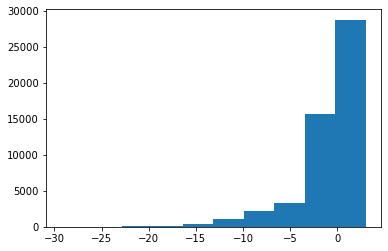

In [16]:
plt.hist(gal['vlosn'])

In [14]:
# msbins = np.arange(10.1,11.75,0.1)
# rbins = np.arange(0.,3.35,0.35)

msbins = np.linspace(9.05,11.7,50)
rbins = np.arange(0.,3.,0.1)+0.1

q = computeFraction('quenching',path=fl.root,key='test')
q.add_probabilities(qf,Po,Pi,Pn,rn)
q.run_kde('smass', mass, msbins, write=True, nBootStrap=10, bw=0.3,radial_cut=False)
q.run_kde('radii', rn, rbins, write=True, nBootStrap=10, bw=0.2,radial_cut=True)


In [ ]:
nBoot=10
bt_mask = bt>=0.
bt2 = np.where(bt>=0.5,1.,bt)
bt2 = np.where(bt<0.5,0.,bt2)

q = computeFraction('BT',path=fl.root,key='test')
q.add_probabilities(bt2[bt_mask],Po[bt_mask],Pi[bt_mask],Pn[bt_mask],rn[bt_mask])
q.run_kde('smass', mass[bt_mask], msbins, write=True, nBootStrap=nBoot, bw=0.3)
q.run_kde('radii', rn[bt_mask], rbins, write=True, nBootStrap=nBoot, bw=0.2,radial_cut=True)


In [22]:
# q = computeFraction('elliptical',path=fl.root,key='test')
# q.add_probabilities(ell,Po,Pi,Pn,Pf)
# q.run_kde('smass', mass, msbins, write=True, nBootStrap=100, bw=0.3)
# q.run_kde('radii', rn, rbins, write=True, nBootStrap=100, bw=0.2)

# q = computeFraction('Bulge',path=fl.root,key='test')
# q.add_probabilities(s0,Po,Pi,Pn,Pf)
# q.run_kde('smass', mass, msbins, write=True, nBootStrap=100, bw=0.3)
# q.run_kde('radii', rn, rbins, write=True, nBootStrap=100, bw=0.2)

# q = computeFraction('BT',path=fl.root,key='test')
# q.add_probabilities(bt,Po,Pi,Pn,Pf)
# q.run_kde('smass', mass, msbins, write=True, nBootStrap=100, bw=0.3)
# q.run_kde('radii', rn, rbins, write=True, nBootStrap=100, bw=0.2)


## Ploting Functions

In [7]:
import matplotlib.pyplot as plt

In [68]:
xlabels = {'cross_time':r't$_{cross}$ [Gyr]','smass':r'Log($M_\star/M_{\odot}$)','radii':r'R/R$_{200m}$'}
label1 = ['Orbital', 'Infall', 'Interlopers','Field']
label2 = ['Orbital-Infall', 'Orbital-Interlopers', 'Infall-Interlopers', 'Infall-Field']

In [69]:
def get_percentile(y):
    a1,a2,a3 = np.nanpercentile(y,[25,50,75])
    ylow,yhig = a1-3.*(a3-a1)/2.,a3+3.*(a3-a1)/2.
    return ylow,yhig

In [117]:
key    = 'magTH'
name   = 'elliptical'
xlabel = 'radii'
save   = False

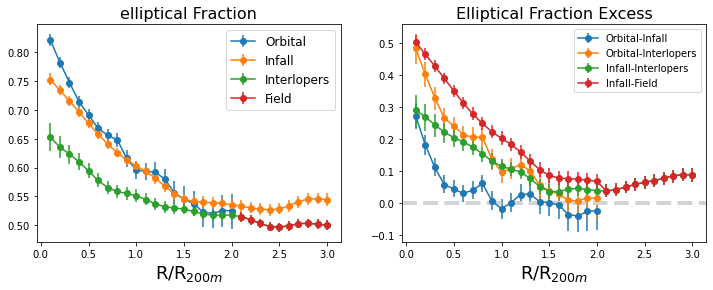

In [118]:
fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
x = np.loadtxt(fname).T

fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
count = np.zeros_like(x[0])
for i in range(4):
    ii = 4*i + 1
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=label1[i], fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
#plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
plt.title('%s Fraction'%name,fontsize=16)

plt.subplot(1, 2, 2)
for i in range(4):
    ii = (4*i + 1)+16
    x[ii] = np.where(x[ii]<-.75,np.nan,x[ii])
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), label=label2[i], ls='-', fmt='o')

plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.legend()
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,f'plots/quenching_pannel_{name}_{xlabel}.png')

In [120]:
key    = 'magTH'
name   = 'BT'
xlabel = 'smass'
save   = False

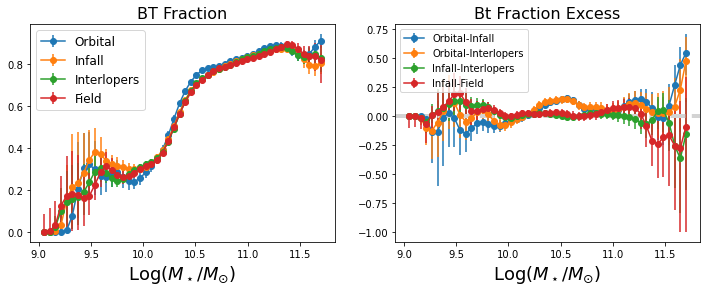

In [121]:
fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
x = np.loadtxt(fname).T

fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
count = np.zeros_like(x[0])
for i in range(4):
    ii = 4*i + 1
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=label1[i], fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
#plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
plt.title('%s Fraction'%name,fontsize=16)

plt.subplot(1, 2, 2)
for i in range(4):
    ii = (4*i + 1)+16
    x[ii] = np.where(x[ii]<-.75,np.nan,x[ii])
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), label=label2[i], ls='-', fmt='o')

plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.legend()
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x
if save:
    save_figures(fig,f'plots/quenching_pannel_{name}_{xlabel}.png')

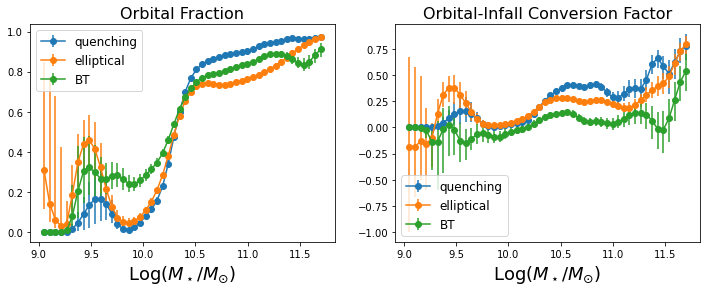

In [122]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

i=0
ii = 4*i + 1
names = ['quenching','elliptical','BT']
for name in names:
    fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=name, fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.title('Orbital Fraction',fontsize=16)

plt.subplot(1, 2, 2)
i=0
ii = (4*i + 1)+16
names = ['quenching','elliptical','BT']
for name in names:
    fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=name, fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.title('Orbital-Infall Conversion Factor',fontsize=16)

del x
if save:
    save_figures(fig,f'plots/quenching_pannel_{name}_{xlabel}.png')

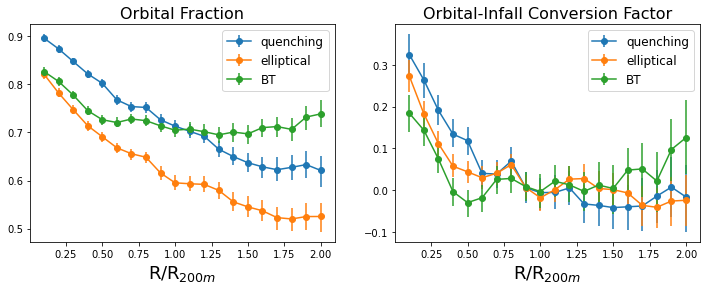

In [123]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
xlabel = 'radii'
i=0
ii = 4*i + 1
names = ['quenching','elliptical','BT']
for name in names:
    fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=name, fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.title('Orbital Fraction',fontsize=16)

plt.subplot(1, 2, 2)
i=0
ii = (4*i + 1)+16
for name in names:
    fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=name, fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.title('Orbital-Infall Conversion Factor',fontsize=16)

del x
if save:
    save_figures(fig,f'plots/quenching_pannel_{name}_{xlabel}.png')

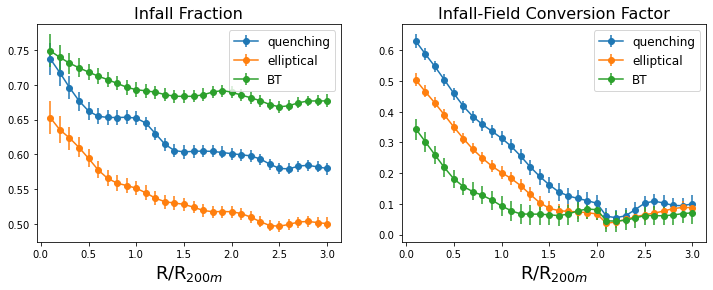

In [124]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
xlabel = 'radii'
i=2
ii = 4*i + 1
names = ['quenching','elliptical','BT']
for name in names:
    fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=name, fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.title('Infall Fraction',fontsize=16)

plt.subplot(1, 2, 2)
i=3
ii = (4*i + 1)+16
for name in names:
    fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
    x = np.loadtxt(fname).T
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=name, fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.title('Infall-Field Conversion Factor',fontsize=16)

del x
if save:
    save_figures(fig,f'plots/quenching_pannel_{name}_{xlabel}.png')

In [77]:
key    = 'test'
name   = 'elliptical'
xlabel = 'smass'
save   = False

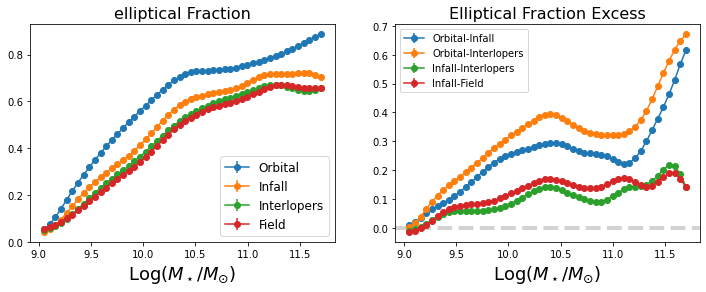

In [78]:
fname = fl.root+f'outputs/{key}/{name}_{xlabel}.npy'
x = np.loadtxt(fname).T

fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
count = np.zeros_like(x[0])
for i in range(4):
    ii = 4*i + 1
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), ls='-', label=label1[i], fmt='o')

plt.legend(fontsize=12)
plt.xlabel(xlabels[xlabel],fontsize=18)
#plt.xlabel(r'Log($M_\star/M_{\odot}$)',fontsize=16)
plt.title('%s Fraction'%name,fontsize=16)

plt.subplot(1, 2, 2)
for i in range(4):
    ii = (4*i + 1)+16
    x[ii] = np.where(x[ii]<-.75,np.nan,x[ii])
    p = plt.errorbar(x[0], x[ii], yerr=np.vstack([x[ii+1],x[ii+2]]), label=label2[i], ls='-', fmt='o')

plt.axhline(0.,ls='--',lw=4,color='lightgray')
plt.xlabel(xlabels[xlabel],fontsize=18)
plt.legend()
plt.title('%s Fraction Excess'%name.capitalize(),fontsize=16)

del x

if save:
    save_figures(fig,f'plots/quenching_pannel_{name}_{xlabel}.png')

In [15]:
def save_figures(fig,fname,is_tight=False):
    if is_tight: fig.tight_layout()
    fig.savefig(fname,transparent=False,facecolor='w',dpi=100)